# Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
#import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import json

In [2]:
#Read logins json, converting dates to datetime index
df = pd.read_json("logins.json",convert_dates=True)

In [3]:
#Explore data
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#Explore data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
#Set index as datetime index to allow for 15-min resampling
df = df.set_index(df['login_time']).sort_index()

In [6]:
#Initialize count column
df['number_of_logins'] = 1

In [7]:
#Resample aggregating counts over 15 minute intervals
df = df.resample('15T').count()

In [8]:
#Drop extra login_time column
df = df.drop(['login_time'],axis=1)

In [9]:
#Extract day of the week
df['weekday'] = df.index.dayofweek

#Extract month
df['month'] = df.index.month

#Extract hour
df['hour'] = df.index.hour

In [10]:
df.head()

,number_of_logins,weekday,month,hour
login_time,,,,
1970-01-01 20:00:00,2,3,1,20
1970-01-01 20:15:00,6,3,1,20
1970-01-01 20:30:00,9,3,1,20
1970-01-01 20:45:00,7,3,1,20
1970-01-01 21:00:00,1,3,1,21


In [11]:
df.tail()

,number_of_logins,weekday,month,hour
login_time,,,,
1970-04-13 17:45:00,5,0,4,17
1970-04-13 18:00:00,5,0,4,18
1970-04-13 18:15:00,2,0,4,18
1970-04-13 18:30:00,7,0,4,18
1970-04-13 18:45:00,6,0,4,18


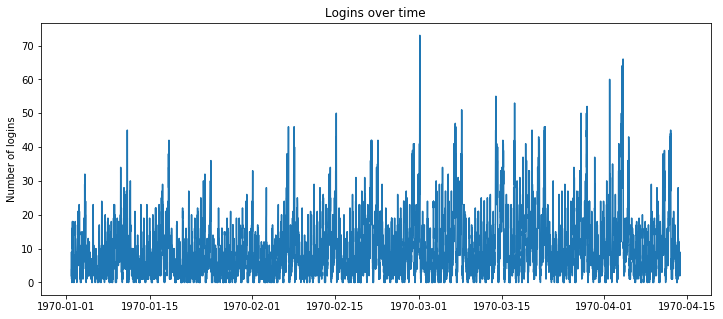

In [12]:
#Plot number of logins vs. time (15 minute intervals)  
plt.figure(figsize=(12,5))
_ = plt.plot(df['number_of_logins'])
_ = plt.ylabel('Number of logins')
_ = plt.title('Logins over time')

We can observe a cyclic pattern in logins with the highest number of logins being around March 1st, 1970. Overall, the number of logins appear to be increasing slightly. We can now look at any patterns in the number of logins on a daily, monthly and hourly basis.

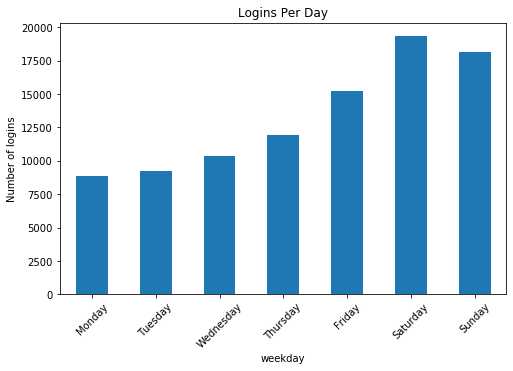

In [13]:
#logins on a daily basis
plt.figure(figsize=(8,5))
_ = df.groupby('weekday')['number_of_logins'].sum().plot(kind='bar')
_ = plt.xticks([0,1,2,3,4,5,6], 
           ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
_ = plt.ylabel('Number of logins')
_ = plt.title('Logins Per Day')

We can observe an upward trend in logins as the week goes on, with the highest number of logins being on Saturdays and the lowest number on Mondays and Tuesdays.

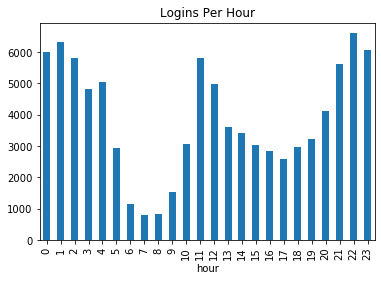

In [15]:
#logins on an hourly basis
_ = df.groupby('hour')['number_of_logins'].sum().plot(kind='bar')
_ = plt.title('Logins Per Hour')

A cyclic cycle can again be observed throughout the day. The highest number of logins (i.e. the highest demand) is late at night (10 pm and 1 am) and around lunch time (11-12 pm).

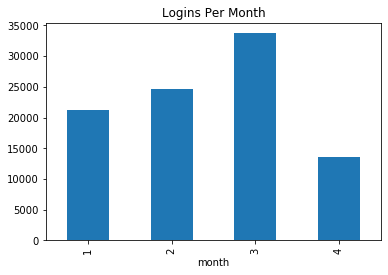

In [17]:
#logins on a monthly basis
_ = df.groupby('month')['number_of_logins'].sum().plot(kind='bar')
_ = plt.title('Logins Per Month')

The highest demand was in March, coinciding with the highest peak in the logins time plot. It should be noted that we only have data available until April 13 so the drop in demand April is not representative of the demand for the entire month. If we assume similar demand in the later half of the month, the demand would still be higher than January and February, albeit still slightly lower than the demand in March. I would look into any special deals or offers that were implemented in March to better understand the uptick in demand.

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

**1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?**


I would choose the percentage increase in activity (i.e. number of rides) per driver as the key measure of success, especially during the slow times per city. This would allow us to determine if reimbursing toll costs results in an overall increase in the number of rides per driver, which would ultimately mean an increase in Ultimate's revenue.

**2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:**

*a. how you will implement the experiment*

*b. what statistical test(s) you will conduct to verify the significance of the
observation*

*c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.*

I would implement A/B testing with 2 sets of drivers: a test group and a control group. The test group would have all toll costs reimbursed while the control group would still have to pay their tolls. The null hypothesis is that there is no change in the number of rides between the test group and the control group. The alternative hypothesis is that the test group has more rides than the control group. I would test the statistical significane of the results using a 2-sample t-test with a 95% confidence interval (p-value of 0.05). If the null hypothesis is rejected and the alternative hypothesis, I would recommend the tolls be reimbursed. Otherwise, I would recommend against it.

# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

### Loading Data

In [18]:
#load data into dataframe
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

In [19]:
#Explore data
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Note that the dataframe has missing values and the date columns are not of type datetime. Let's take care of the column types first and create our target variable of active vs. inactive users to predict rider retention.

### Converting Date Columns and Creating Target Variable

In [21]:
#Convert signupdate and lasttrip data into datetime columns
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [22]:
#When is the last trip in the data? User will be considered active if his last trip was within 30 days of this date
df.last_trip_date.sort_values(ascending=False)[0]

Timestamp('2014-06-17 00:00:00')

In [23]:
#When is 30 days before last date
import datetime
s = '2014-06-17'
d = datetime.datetime.strptime(s, '%Y-%m-%d') - datetime.timedelta(days=30)
print(d.strftime('%m/%d/%Y'))

05/18/2014


Any user that has taken a trip on or after May 18, 2014 will be considered active. Any user whose last trip was before May 17, will be considered inactive.

In [24]:
#Label target variable column as "active or not"
df['active_or_not'] = (df.last_trip_date > '2014-05-17').astype(int)

Since the target column active_or_not was directly derived from last_trip_date, we will trip the original column to avoid multicollinearity issues.

In [25]:
#drop last_trip_date to avoid multicollinearity
df.drop(['last_trip_date'],axis=1,inplace=True)

### Missing Values

We have approximately 200-400 missing values from the average rating columns, we will replace these values with the mean of their respective columns. We will then drop any additional rows that have missing data in the phone columns.

In [26]:
#replace missing data with average
df["avg_rating_by_driver"] = df["avg_rating_by_driver"].fillna(round(df.avg_rating_by_driver.mean(),1))
df["avg_rating_of_driver"] = df["avg_rating_of_driver"].fillna(round(df.avg_rating_by_driver.mean(),1))

In [27]:
#drop rows with missing phone values
df.dropna(inplace=True)

### Converting categorial/non-numerical columns into numerical features

We have 3 columns that are non-numerical in nature: city, phone, signup_date. We will now convert them into numerical features.

In [28]:
#one-hot encoding on city column
city_encoded = pd.get_dummies(df.city.apply(pd.Series).stack(),drop_first=True).sum(level=0)
df = df.join(city_encoded)

In [29]:
#one-hot encoding on phone column
phone_encoded = pd.get_dummies(df.phone.apply(pd.Series).stack(),drop_first=True).sum(level=0)
df = df.join(phone_encoded)

In [30]:
#Drop original iphone column and astapor column
df = df.drop(columns = ['city','phone'])

In order to use the signup_date, we will convert the date into weekday columns. This will allow us to understand if the day a user signs up (e.g. Saturday instead of Monday) has any impact on their retention. 

In [31]:
#Extract date
date = df[['signup_date']]
date = date.set_index('signup_date')

In [32]:
#Exract signup day
df['signup_day'] = date.index.dayofweek

In [33]:
#Drop signup_date
df = df.drop(['signup_date'],axis=1)

Just for consistency's sake, we will convert the ultimate_black_user column from boolean to int

In [34]:
#Convert ultimate_black_user from boolean to int
df['ultimate_black_user'] = df['ultimate_black_user'].astype('int')

In [35]:
#Convert all column names to lowercase and remove punctuations
df.columns = df.columns.str.replace(' ','_').str.lower()
df=df.rename(columns = {'''king's_landing''':'kings_landing'})

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
trips_in_first_30_days    49604 non-null int64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
surge_pct                 49604 non-null float64
ultimate_black_user       49604 non-null int64
weekday_pct               49604 non-null float64
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
active_or_not             49604 non-null int64
kings_landing             49604 non-null uint8
winterfell                49604 non-null uint8
iphone                    49604 non-null uint8
signup_day                49604 non-null int64
dtypes: float64(6), int64(4), uint8(3)
memory usage: 4.3 MB


In [37]:
#Set column types as categorical
cat_columns = ['active_or_not','kings_landing','winterfell','iphone','ultimate_black_user','signup_day']
for i in cat_columns:
    df[i] = df[i].astype('category')

In [38]:
df.reset_index(inplace=True,drop=True)

Our data now looks good and is ready for further multicollinearity analysis and modeling!

### EDA - Multicollinearity Analysis

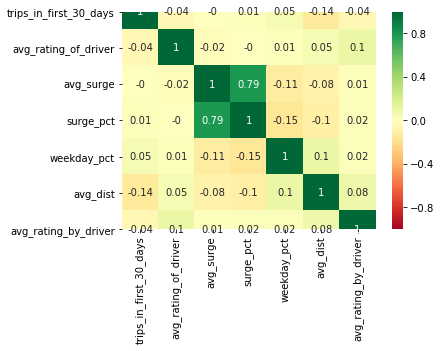

In [37]:
#Correlation matrix
_ = sns.heatmap(df.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)

The features avg_surge and surge_pct have a high correlation factor of around 0.8. We should potentially drop one of them but let's check the variance inflation factors (VIFs) first to determine which one to drop.

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Multicollinearity analysis
#Get features
feature_x = df.drop(['active_or_not'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
7,68.780275,avg_rating_by_driver
1,52.552474,avg_rating_of_driver
2,50.351993,avg_surge
11,4.284209,signup_day
5,4.015099,weekday_pct


Uh-oh! Looks like we've got a few features with some high VIF values, indicating strong signs of multicollinearity. Let's remove avg_rating_by_driver from our dataset and re-do the VIF analysis.

In [41]:
df = df.drop(columns=['avg_rating_by_driver'])

In [42]:
#Multicollinearity analysis
#Get features
feature_x = df.drop(['active_or_not'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
2,39.182262,avg_surge
1,33.460988,avg_rating_of_driver
10,4.213482,signup_day
5,3.956638,weekday_pct
9,3.279152,iphone


That's better but there still appears to be multicollinearity due to the avg_surge variable since the VIF factor is greater than in the 10-15 range. Let's remove this feature as well.

In [43]:
df = df.drop(columns=['avg_surge'])

In [44]:
#Multicollinearity analysis
#Get features
feature_x = df.drop(['active_or_not'],axis=1)
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
1,12.284643,avg_rating_of_driver
9,4.100819,signup_day
4,3.862062,weekday_pct
8,3.230511,iphone
7,2.343005,winterfell


Much better!

### What fraction of the observed users were retained?

45.5 % of observed users were retained


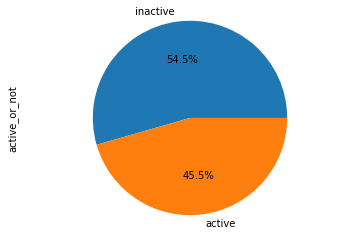

In [45]:
print(format(df.active_or_not.astype('int').sum()/df.active_or_not.astype('int').count()*100,'1.1f'), '% of observed users were retained')
_ = df.active_or_not.value_counts().plot(kind='pie',labels=['inactive','active'],autopct='%1.1f%%')
_ = plt.axis('equal')

### Boxplots of numerical features

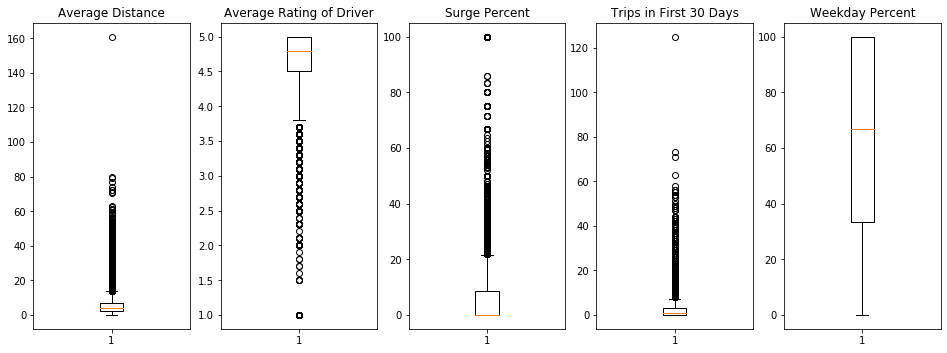

In [46]:
cleaned = df
fig, axs = plt.subplots(1,5,figsize=(14,5))
_ = axs[0].boxplot(cleaned.avg_dist)
axs[0].set_title('Average Distance')
_ = axs[1].boxplot(cleaned.avg_rating_of_driver)
axs[1].set_title('Average Rating of Driver')
_ = axs[2].boxplot(cleaned.surge_pct)
axs[2].set_title('Surge Percent')
_ = axs[3].boxplot(cleaned.trips_in_first_30_days)
axs[3].set_title('Trips in First 30 Days')
_ = axs[4].boxplot(cleaned.weekday_pct)
axs[4].set_title('Weekday Percent')
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=1.5, wspace=0.2)

Looks like we do have some outliers but let's keep them in our dataset for now.

### Feature Scaling of Numerical Features

In [47]:
from sklearn.preprocessing import MinMaxScaler

#Initialize scaler
scaler = MinMaxScaler() 
  
# Scaled features
df_transformed = scaler.fit_transform(df[['avg_dist', 'avg_rating_of_driver', 'surge_pct',
                                               'trips_in_first_30_days','weekday_pct']])

#Convert scaled features to dataframe
scaled_df = pd.DataFrame(df_transformed,columns=['avg_dist', 'avg_rating_of_driver', 'surge_pct',
                                               'trips_in_first_30_days','weekday_pct'])
scaled_df.describe()

,avg_dist,avg_rating_of_driver,surge_pct,trips_in_first_30_days,weekday_pct
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,0.035943,0.908398,0.088753,0.018218,0.608838
std,0.035224,0.142484,0.199890,0.030346,0.370862
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015035,0.875000,0.000000,0.000000,0.333000
50%,0.024105,0.950000,0.000000,0.008000,0.667000
75%,0.043054,1.000000,0.087000,0.024000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
#Drop unscaled columns
cat_frame = df.drop(['avg_dist', 'avg_rating_of_driver', 'surge_pct',
                                               'trips_in_first_30_days','weekday_pct'],axis=1)
df_scaled = scaled_df.join(cat_frame)

In [49]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 11 columns):
avg_dist                  49604 non-null float64
avg_rating_of_driver      49604 non-null float64
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null float64
weekday_pct               49604 non-null float64
ultimate_black_user       49604 non-null category
active_or_not             49604 non-null category
kings_landing             49604 non-null category
winterfell                49604 non-null category
iphone                    49604 non-null category
signup_day                49604 non-null category
dtypes: category(6), float64(5)
memory usage: 2.2 MB


Everything looks good! Time for some machine learning.

## Machine Learning

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
#Drop target variable from X
X = df_scaled.drop(['active_or_not'],axis=1)
y = df_scaled['active_or_not']

In [52]:
#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Now that we have split the data into a training and test set, we will test out 2 different classification algorithms: logistic regression and random forest.

### Logistic Regression

In [53]:
%%time 

from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(solver='liblinear',max_iter = 500, random_state=42)

#Cross-validate on training set
cv_accuracy_lr = cross_val_score(lr, X_train, y_train,cv=5,scoring='accuracy')

# train model
lr.fit(X_train, y_train)

# predict on test data
y_pred_lr = lr.predict(X_test)

CPU times: user 1.32 s, sys: 177 ms, total: 1.49 s
Wall time: 1.9 s


In [54]:
print("Train Accuracy:",format(np.mean(cv_accuracy_lr),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_lr),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_lr),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_lr))

Train Accuracy: 0.67179
Test Accuracy: 0.66752
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6266         1831
Actual 1         3117         3668
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      8097
           1       0.67      0.54      0.60      6785

    accuracy                           0.67     14882
   macro avg       0.67      0.66      0.66     14882
weighted avg       0.67      0.67      0.66     14882



### Random Forest

In [55]:
%%time

from sklearn.ensemble import RandomForestClassifier

# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='accuracy')

# train model
rf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test)

CPU times: user 9.26 s, sys: 416 ms, total: 9.67 s
Wall time: 10.4 s


In [56]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.72922
Test Accuracy: 0.72181
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6021         2076
Actual 1         2064         4721
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8097
           1       0.69      0.70      0.70      6785

    accuracy                           0.72     14882
   macro avg       0.72      0.72      0.72     14882
weighted avg       0.72      0.72      0.72     14882



Looks like our Random Forest Classifier outperforms our Logistic Regression model. Let's do some outlier analysis.

### Outlier Analysis

In [57]:
%%time

sm_y = np.asarray(y).astype(float)
sm_X = np.asarray(X).astype(float)
sm_X = sm.add_constant(sm_X)
model = sm.OLS(sm_y,sm_X).fit()

#Get influence data
influence = model.get_influence()

#c is the cook's distance and p is p-value
(c, p) = influence.cooks_distance

CPU times: user 153 ms, sys: 46.4 ms, total: 199 ms
Wall time: 159 ms


In [58]:
c_df = pd.DataFrame(c)
print(c_df.sort_values(0,ascending=False).head())
print(c_df.sort_values(0,ascending=False).tail())

              0
18370  0.037532
20542  0.027325
99     0.008043
39965  0.004179
36181  0.003905
                  0
6091   4.896771e-10
40256  1.717066e-10
38679  1.403729e-10
25778  9.102562e-11
43386  2.677988e-11


Text(0.5, 1.0, "Cook's D")

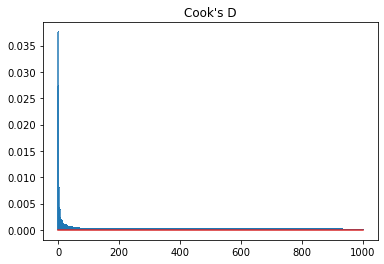

In [59]:
plt.stem(np.arange(1000), c_df.sort_values(0,ascending=False).head(1000), markerfmt=",",use_line_collection=True)
plt.title('Cook\'s D')

Looks like we might have a couple of outliers at index 18370 and index 20542. How is our random forest model performance affected if we remove these outliers?

### Performance without outliers

In [60]:
#Drop outliers
df_nooutliers = df_scaled.drop([18370,20542])

#Drop target variable from X
X = df_nooutliers.drop(['active_or_not'],axis=1)
y = df_nooutliers['active_or_not']

#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [61]:
%%time

# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='accuracy')

# train model
rf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test)

CPU times: user 9.5 s, sys: 434 ms, total: 9.93 s
Wall time: 10.3 s


In [63]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.72875
Test Accuracy: 0.72744
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6072         2059
Actual 1         1997         4753
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      8131
           1       0.70      0.70      0.70      6750

    accuracy                           0.73     14881
   macro avg       0.73      0.73      0.73     14881
weighted avg       0.73      0.73      0.73     14881



Interestingly, removing the outliers seems to slightly negatively affect our training accuracy. We will therefore keep these outliers in the data.

### Random Forest - Final Model

In [62]:
#Drop target variable from X
X = df_scaled.drop(['active_or_not'],axis=1)
y = df_scaled['active_or_not']

#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [63]:
%%time

# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training set
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='accuracy')

# train model
rf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test)

CPU times: user 9.59 s, sys: 442 ms, total: 10 s
Wall time: 10.3 s


In [64]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.72922
Test Accuracy: 0.72181
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         6021         2076
Actual 1         2064         4721
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8097
           1       0.69      0.70      0.70      6785

    accuracy                           0.72     14882
   macro avg       0.72      0.72      0.72     14882
weighted avg       0.72      0.72      0.72     14882



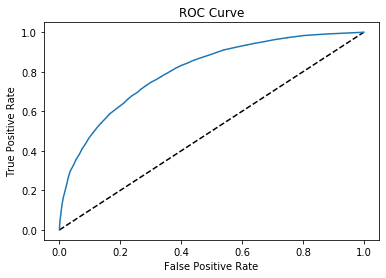

In [65]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

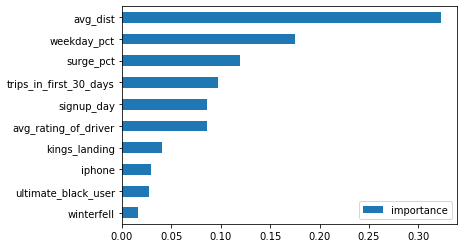

In [66]:
feature_importances_rf = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances_rf.plot(kind='barh')

It looks like the average distance is the most important feature in predicting rider retention. Active users tend to take shorter, but more frequent trips while inactive users tend to take longer but less frequent trips, especially in the first 30 days. This can be seen by looking at the mean average distance for active vs. inactive drivers and looking at the number of trips taken in the first 30 days for active vs. inactive drivers (see below).

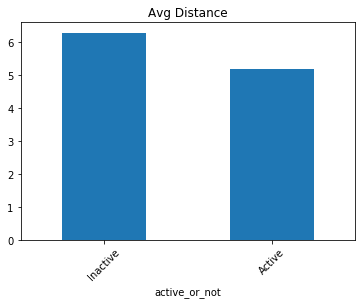

In [68]:
_ = df.groupby('active_or_not')['avg_dist'].mean().plot(kind='bar')
_ = plt.title('Avg Distance')
_ = plt.xticks([0,1],['Inactive','Active'],rotation=45)

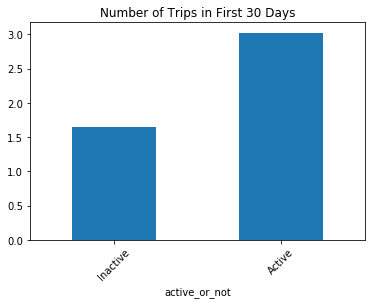

In [80]:
df.groupby('active_or_not')['trips_in_first_30_days'].mean().plot(kind='bar')
_ = plt.title('Number of Trips in First 30 Days')
_ = plt.xticks([0,1],['Inactive','Active'],rotation=45)